# Loop Hydrodynamics: Bundle Heating Model
Run EBTEL simulations for the bundle heating model

In [1]:
import os
import sys
import subprocess
import multiprocessing

import numpy as np
import h5py
import astropy.units as u
import matplotlib.pyplot as plt

import synthesizAR
from synthesizAR.interfaces.ebtel import EbtelInterface
from synthesizAR.util import write_xml,read_xml

sys.path.append('../../scripts/')
from bundle_heating_model import BundleHeatingModel

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
noaa1158 = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


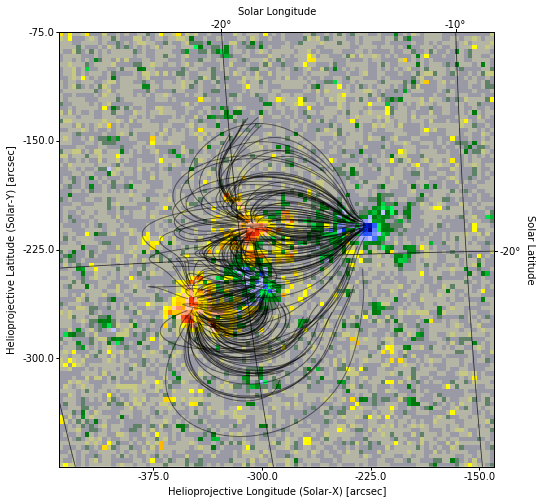

In [3]:
noaa1158.peek(line_frequency=20)

In [4]:
heating_options = {
    'stress': 0.3,
    'event_duration': 200 * u.s,
    'storm_duration': 500. * u.s
}
num_bins = 50

In [5]:
heating_model = BundleHeatingModel(heating_options, noaa1158, num_bins=num_bins,)

FloatProgress(value=0.0)

In [6]:
base_config = read_xml('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 3e4
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-8
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [7]:
ebtel_interface = EbtelInterface(base_config,heating_model,
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/hydro_config/',
                                 '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/hydro_results/')

In [8]:
heating_model.constrain_number_storms(base_config['total_time']*u.s)

Error = 0.7754269889919296, phi = 0.22457301100807037, n_storms = 177
Error = 0.5243694056306087, phi = 0.4756305943693912, n_storms = 269
Error = 0.43145980979324006, phi = 0.5685401902067599, n_storms = 385
Error = 0.14935967019759366, phi = 0.8506403298024063, n_storms = 442
Error = 0.01838646511070241, phi = 1.0183864651107024, n_storms = 433
Error = 0.10764130557890794, phi = 0.8923586944210921, n_storms = 479
Error = 0.1075585676035049, phi = 1.107558567603505, n_storms = 427
Error = 0.04528344822373742, phi = 1.0452834482237374, n_storms = 407
Error = 0.06389910658155562, phi = 0.9361008934184444, n_storms = 433
Error = 0.0024409999336674204, phi = 1.0024409999336674, n_storms = 431


In [9]:
noaa1158.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [10]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [11]:
pool = multiprocessing.Pool()

In [12]:
runs = pool.map_async(ebtel_runner,noaa1158.loops)
runs.wait()

In [13]:
noaa1158.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

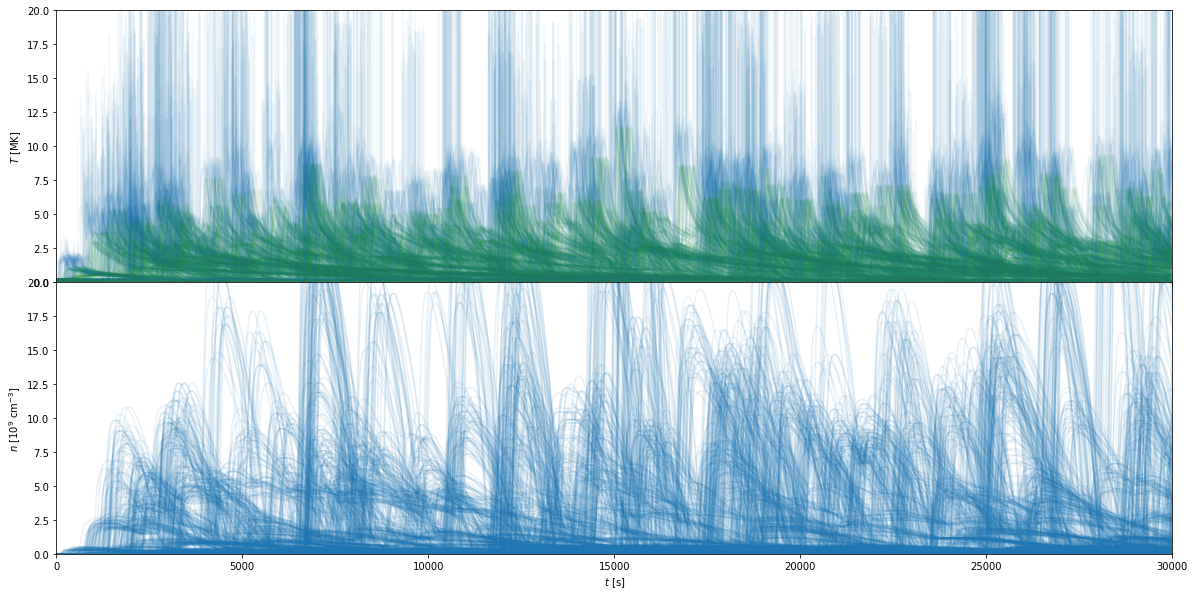

In [15]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in noaa1158.loops[::5]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.05)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.05)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.1)
axes[0].set_xlim(0,base_config['total_time'])
axes[0].set_ylim(0,20)
axes[1].set_ylim(0,20)
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [16]:
noaa1158.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/field_checkpoint')

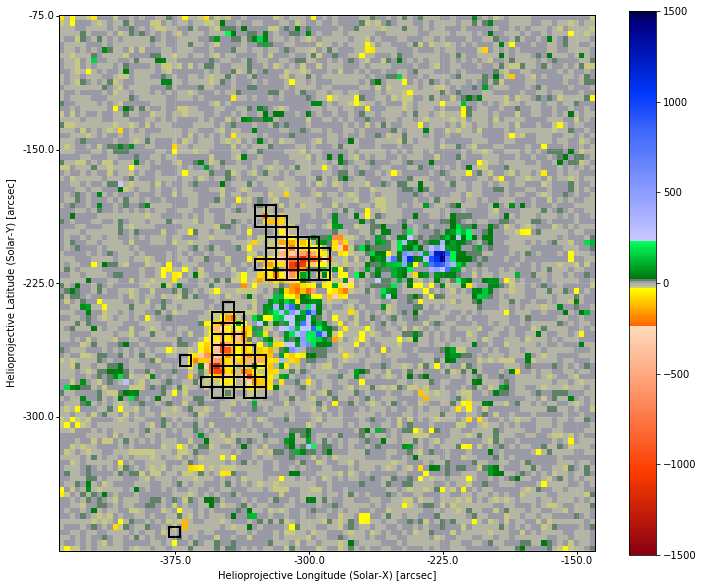

In [18]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=noaa1158.magnetogram)
im = noaa1158.magnetogram.plot(title=False,cmap='hmimag',axes=ax,vmin=-1.5e3,vmax=1.5e3)
#colors = seaborn.color_palette('Set1', len(bundles))
for i,b in enumerate(heating_model.bundles):
    #for l in b[:10]:
    #    loop_hpc = (heeq_to_hcc_coord(*l.coordinates.T, noaa1158.magnetogram.observer_coordinate)
    #                .transform_to(noaa1158.magnetogram.coordinate_frame))
    #    ax.plot_coord(loop_hpc, color=colors[i],alpha=0.75)
    noaa1158.magnetogram.draw_rectangle(b.corners[0],
                                        b.corners[1].Tx - b.corners[0].Tx,
                                        b.corners[1].Ty - b.corners[0].Ty,
                                        axes=ax,color='k',lw=2)
fig.colorbar(im,ax=ax)

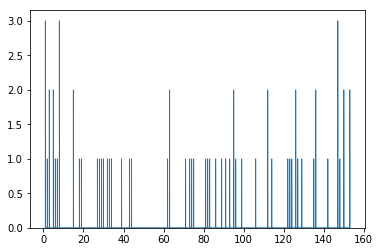

In [28]:
plt.hist([len(b.loops) for b in heating_model.bundles],histtype='step',bins=5000);